In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from utils.test_handler import ACDC2017TestHandler
from plotting.learning_curves import loss_plot
from plotting.uncertainty_plots import analyze_slices

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Assess performance of base and MC-dropout models on left out test set 

#### Set variables

In [2]:
# Constants aka fixed variables
ROOT_DIR = "/home/jorg/repository/dcnn_acdc"
LOG_DIR = os.path.join(ROOT_DIR, "logs")
CYCLE_OFFSET = 100000
# set seeds
SEED = 4325
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.enabled = True
np.random.seed(SEED)
# newest baseline: 20180319_10_49_05_dcnnv1_150000E_lr2e02
exp_base_model = os.path.join(LOG_DIR, "20180319_10_49_05_dcnnv1_150000E_lr2e02")
# Jelmers base model with brier-score
exp_base_bs_model = os.path.join(LOG_DIR, "20180321_11_14_04_dcnnv1_150000E_lr2e04")
# MC dropout models
exp_mc005_model = os.path.join(LOG_DIR, "20180320_17_39_16_dcnn_mcv1_150000E_lr2e02")
exp_mc01_model = os.path.join(LOG_DIR, "20180317_17_34_02_dcnn_mcv1_150000E_lr2e02")
exp_mc025_model = os.path.join(LOG_DIR, "20180318_16_31_57_dcnn_mcv1_150000E_lr2e02")
exp_mc04_model = os.path.join(LOG_DIR, "20180321_14_42_12_dcnn_mcv1_150000E_lr2e02")
# 20180308_12_05_35_dcnn_mcv1_150000E_lr2e02 p=0.1
# mix model with 0.1 and 0.2 (deeper layers) drop out
exp_mc_mix_model = os.path.join(LOG_DIR, "20180317_17_42_52_dcnn_mc_mixv1_150000E_lr2e02")
# mc-drop 0.05 with brier-score as loss function
exp_mc005_bs_model = "20180322_14_53_11_dcnn_mcv1_150000E_lr2e04"
# mc-drop 0.1 with brier-score as loss function
exp_mc01_bs_model = "20180320_10_14_08_dcnn_mcv1_150000E_lr2e04"


## Load experimental data and test data set

In [3]:
exper_base = ExperimentHandler.load_experiment(exp_base_model)
exper_hdl_base = ExperimentHandler(exper_base, use_logfile=False)
exper_hdl_base.set_root_dir(ROOT_DIR)
exper_hdl_base.set_model_name("DCNN baseline")

exper_base_bs = ExperimentHandler.load_experiment(exp_base_bs_model)
exper_hdl_base_bs = ExperimentHandler(exper_base_bs, use_logfile=False)
exper_hdl_base_bs.set_root_dir(ROOT_DIR)
exper_hdl_base_bs.set_model_name("DCNN baseline (Brier-loss)")

exper_mc005 = ExperimentHandler.load_experiment(exp_mc005_model)
exper_hdl_mc005 = ExperimentHandler(exper_mc005, use_logfile=False)
exper_hdl_mc005.set_root_dir(ROOT_DIR)
exper_hdl_mc005.set_model_name("MC-dropout (p=0.05)")

exper_mc01 = ExperimentHandler.load_experiment(exp_mc01_model)
exper_hdl_mc01 = ExperimentHandler(exper_mc01, use_logfile=False)
exper_hdl_mc01.set_root_dir(ROOT_DIR)
exper_hdl_mc01.set_model_name("MC-dropout (p=0.1)")

exper_mc025 = ExperimentHandler.load_experiment(exp_mc025_model)
exper_hdl_mc025 = ExperimentHandler(exper_mc025, use_logfile=False)
exper_hdl_mc025.set_root_dir(ROOT_DIR)
exper_hdl_mc025.set_model_name("MC-dropout (p=0.25)")

exper_mc04 = ExperimentHandler.load_experiment(exp_mc04_model)
exper_hdl_mc04 = ExperimentHandler(exper_mc04, use_logfile=False)
exper_hdl_mc04.set_root_dir(ROOT_DIR)
exper_hdl_mc04.set_model_name("MC-dropout (p=0.4)")

exper_mc_mix = ExperimentHandler.load_experiment(exp_mc_mix_model)
exper_hdl_mc_mix = ExperimentHandler(exper_mc_mix, use_logfile=False)
exper_hdl_mc_mix.set_root_dir(ROOT_DIR)
exper_hdl_mc_mix.set_model_name("MC-dropout (p=Mix)")

exp_hdl_mc01_bs = ExperimentHandler.load_experiment(exp_mc01_bs_model)
exp_hdl_mc01_bs = ExperimentHandler(exp_hdl_mc01_bs, use_logfile=False)
exp_hdl_mc01_bs.set_root_dir(ROOT_DIR)
exp_hdl_mc01_bs.set_model_name("MC-dropout (p=0.1 / Brier-loss)")

exper_mc005_bs = ExperimentHandler.load_experiment(exp_mc005_bs_model)
exper_hdl_mc005_bs = ExperimentHandler(exper_mc005_bs, use_logfile=False)
exper_hdl_mc005_bs.set_root_dir(ROOT_DIR)
exper_hdl_mc005_bs.set_model_name("MC-dropout (p=0.05 / Brier-loss)")

test_set = ACDC2017TestHandler(exper_config=exper_hdl_base.exper.config, 
                               search_mask=config.dflt_image_name + ".mhd", fold_ids=[1],
                               debug=False, batch_size=20, use_cuda=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Load from /home/jorg/repository/dcnn_acdc/logs/20180319_10_49_05_dcnnv1_150000E_lr2e02/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180321_11_14_04_dcnnv1_150000E_lr2e04/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180320_17_39_16_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180318_16_31_57_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180321_14_42_12_dcnn_mcv1_150000E_lr2e02/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180317_17_42_52_dcnn_mc_mixv1_150000E_lr2e02/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180320_10_14_08_dcnn_mcv1_150000E_lr2e04/stats/exper_stats.dll
Load from /home/jorg/repository/dcnn_acdc/logs/20180322_14_53_11_dcnn_mcv1_150000E_lr2e04/stats/exper_stat

  5%|▌         | 1/20 [00:00<00:10,  1.83it/s]/home/jorg/anaconda2/envs/pyt_0_3_0/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


2 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient012_frame01.mhd
3 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient012_frame13.mhd


 10%|█         | 2/20 [00:01<00:09,  1.85it/s]

4 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient013_frame01.mhd
5 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient013_frame14.mhd


 15%|█▌        | 3/20 [00:01<00:09,  1.85it/s]

6 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient014_frame01.mhd
7 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient014_frame13.mhd


 20%|██        | 4/20 [00:02<00:08,  1.89it/s]

8 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient015_frame01.mhd
9 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient015_frame10.mhd


 25%|██▌       | 5/20 [00:02<00:07,  1.93it/s]

10 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient031_frame01.mhd
11 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient031_frame10.mhd


 30%|███       | 6/20 [00:03<00:07,  1.89it/s]

12 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient032_frame01.mhd
13 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient032_frame12.mhd


 35%|███▌      | 7/20 [00:03<00:07,  1.81it/s]

14 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient033_frame01.mhd
15 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient033_frame14.mhd


 40%|████      | 8/20 [00:04<00:06,  1.78it/s]

16 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient034_frame01.mhd
17 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient034_frame16.mhd


 45%|████▌     | 9/20 [00:05<00:06,  1.74it/s]

18 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient035_frame01.mhd
19 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient035_frame11.mhd


 50%|█████     | 10/20 [00:06<00:06,  1.64it/s]

20 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient051_frame01.mhd
21 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient051_frame11.mhd


 55%|█████▌    | 11/20 [00:06<00:05,  1.62it/s]

22 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient052_frame01.mhd
23 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient052_frame09.mhd


 60%|██████    | 12/20 [00:07<00:04,  1.65it/s]

24 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient053_frame01.mhd
25 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient053_frame12.mhd


 65%|██████▌   | 13/20 [00:07<00:04,  1.70it/s]

26 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient054_frame01.mhd
27 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient054_frame12.mhd


 70%|███████   | 14/20 [00:08<00:03,  1.72it/s]

28 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient055_frame01.mhd
29 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient055_frame10.mhd


 75%|███████▌  | 15/20 [00:08<00:02,  1.73it/s]

30 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient071_frame01.mhd
31 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient071_frame09.mhd


 80%|████████  | 16/20 [00:09<00:02,  1.73it/s]

32 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient072_frame01.mhd
33 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient072_frame11.mhd


 85%|████████▌ | 17/20 [00:09<00:01,  1.74it/s]

34 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient073_frame01.mhd
35 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient073_frame10.mhd


 90%|█████████ | 18/20 [00:10<00:01,  1.74it/s]

36 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient074_frame01.mhd
37 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient074_frame12.mhd


 95%|█████████▌| 19/20 [00:10<00:00,  1.74it/s]

38 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient075_frame01.mhd
39 - /home/jorg/repository/dcnn_acdc/data/Folds/fold1/validate/images/patient075_frame06.mhd


100%|██████████| 20/20 [00:11<00:00,  1.71it/s]

INFO - Successfully loaded 20 ED/ES patient pairs


## Run model evaluation of test set

In [4]:
def test_ensemble(test_set, exper_hdl, mc_samples=10, sample_weights=True, use_uncertainty=False,
                  u_threshold=None, image_range=None, verbose=False, reset_results=False, 
                  store_details=False, generate_stats=False, save_results=False, use_seed=False,
                  do_filter=False):
    # checkpoints = np.arange(CYCLE_OFFSET, 150001, 10000)
    checkpoints = [150000]
    # checkpoints = [10000, 50000, 100000, 150000]
    if reset_results:
        exper_hdl.reset_results()
    
    if use_uncertainty:
        print("INFO - Using {:.2f} as uncertainty threshold".format(std_threshold))
    for checkpoint in checkpoints:
        dcnn_model = exper_hdl.load_checkpoint(verbose=False, drop_prob=exper_hdl.exper.run_args.drop_prob, 
                                               checkpoint=checkpoint)
        if image_range is None:
            image_range = np.arange(len(test_set.images))
        num_of_images = len(image_range)
        print("INFO - Running test on {} images".format(num_of_images))
        for image_num in image_range:
            exper_hdl.test(dcnn_model, test_set, image_num=image_num, sample_weights=sample_weights, 
                           mc_samples=mc_samples, compute_hd=True, use_uncertainty=use_uncertainty, 
                           u_threshold=u_threshold, verbose=verbose, store_details=store_details,
                           use_seed=use_seed, do_filter=do_filter)
        del dcnn_model
    exper_hdl.test_results.compute_mean_stats()
    exper_hdl.test_results.show_results()
    
    if generate_stats:
        print("INFO - generating statistics for {} run(s). May take a while".format(exper_hdl.test_results.N))
        exper_hdl.test_results.generate_all_statistics()
    if save_results:
        exper_hdl.test_results.save_results()

# None means all test images will be evaluated
image_range = None

In [ ]:
mc_samples = 1
sample_weights = False
store_details = False
image_range = None  # [1, 9, 19]
generate_stats = False
save_results = True
exper_hdl_base_bs.logger = None   # exper_hdl_base

test_ensemble(test_set, exper_hdl_base_bs, mc_samples=mc_samples, sample_weights=sample_weights,  
              use_uncertainty=False, 
              u_threshold=0., image_range=image_range, verbose=False, reset_results=True, 
              store_details=store_details, generate_stats=generate_stats, save_results=save_results)


    
print("Ready")

In [41]:
exper_handler = exper_hdl_mc01

image_ids = exper_handler.test_results.image_ids
image_range = [1, 9, 13, 18]
# image_range = np.arange(len(exper_handler.test_results.images))
u_type = "bald"

analyze_slices(exper_handler, image_range=image_range, do_save=True, do_show=False, u_type=u_type)

INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient012/slice_analysis_img_1.pdf
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient035/slice_analysis_img_9.pdf
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient054/slice_analysis_img_13.pdf
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient074/slice_analysis_img_18.pdf


In [5]:
sample_weights = True
mc_samples = 10
store_details = True
image_range = [1, 9, 13, 18]  # [1, 9, 19]
generate_stats = True

save_results = False
#  exper_hdl_mc01 exper_hdl_mc025 exp_hdl_mc01_bs  exper_hdl_mc04  exp_hdl_mc01_bs
exper_handler = exper_hdl_mc01
exper_handler.logger = None

print("INFO - Evaluating model {}".format(exper_handler.exper.model_name))

test_ensemble(test_set, exper_handler, mc_samples=mc_samples, sample_weights=sample_weights,
              use_uncertainty=False, 
              u_threshold=0.05, image_range=image_range, verbose=False, reset_results=True, use_seed=True,
              store_details=store_details, generate_stats=generate_stats, save_results=save_results,
              do_filter=True)


    
print("Ready")



INFO - Evaluating model MC-dropout (p=0.1)
INFO - Running test on 4 images
Image 2 - Test accuracy: test loss -2.558	 dice(RV/Myo/LV): ES 0.63/0.80/0.92 --- ED 0.88/0.84/0.97
Image 2 - Test accuracy: test loss -2.558	 Hausdorff(RV/Myo/LV): ES 33.11/14.28/15.53 --- ED 22.27/7.00/10.10
Image 10 - Test accuracy: test loss -1.394	 dice(RV/Myo/LV): ES 0.76/0.92/0.89 --- ED 0.93/0.86/0.95
Image 10 - Test accuracy: test loss -1.394	 Hausdorff(RV/Myo/LV): ES 18.78/7.54/7.92 --- ED 23.09/7.64/7.64
Image 14 - Test accuracy: test loss -1.165	 dice(RV/Myo/LV): ES 0.64/0.82/0.92 --- ED 0.80/0.82/0.95
Image 14 - Test accuracy: test loss -1.165	 Hausdorff(RV/Myo/LV): ES 23.55/14.00/10.10 --- ED 25.40/15.53/14.82
Image 19 - Test accuracy: test loss -1.792	 dice(RV/Myo/LV): ES 0.73/0.84/0.92 --- ED 0.93/0.81/0.96
Image 19 - Test accuracy: test loss -1.792	 Hausdorff(RV/Myo/LV): ES 20.77/10.93/5.77 --- ED 14.21/15.59/10.85
Test accuracy: 	 dice(RV/Myo/LV): ES 0.69 (0.06)/0.84 (0.04)/0.91 (0.01) --- ED 0

In [ ]:
list_of_stats = exper_handler.test_results.image_probs_categorized[0]
for idx, slice_stats in enumerate(list_of_stats):
    print("----------------------- Slice {} --------------------".format(idx+1))
    print("\tES p-value stddev {:.2E}".format(slice_stats["es_pvalue_mwhitu_std"]))
    print("\tED p-value stddev {:.2E}".format(slice_stats["ed_pvalue_mwhitu_std"]))
    print("\tES p-value BALD {:.2E}".format(slice_stats["es_pvalue_mwhitu_bald"]))
    print("\tED p-value BALD {:.2E}".format(slice_stats["ed_pvalue_mwhitu_bald"]))
    

# Compare performance of models

In [ ]:
exper_hdl_base.logger = None
generate_stats = False

test_ensemble(test_set, exper_hdl_base, mc_samples=1, sample_weights=False, image_range=image_range, verbose=False,
              use_uncertainty=False, reset_results=True)

if generate_stats:
    print("INFO - generating statistics for {} runs. May take a while".format(exper_hdl_base.test_results.N))
    exper_hdl_base.test_results.generate_all_statistics()
print("Ready")


In [13]:
exper_hdl_base.test_results.show_results()

Test accuracy: 	 dice(RV/Myo/LV): ES 0.86 (0.09)/0.87 (0.03)/0.92 (0.08) --- ED 0.92 (0.03)/0.87 (0.03)/0.96 (0.01)
Test accuracy: 	 Hausdorff(RV/Myo/LV): ES 21.40 (16.25)/31.23 (44.79)/10.76 (6.12) --- ED 25.29 (21.49)/58.11 (54.90)/24.59 (35.83)


In [14]:
exper_hdl_mc01.test_results.generate_all_statistics()

In [43]:
# info_type="uncertainty"  or probabilities
# model_names a) "Baseline with p=0.5" b) MC-dropout 0.1  c) MC-dropout-Brier 0.1 
handler = exper_hdl_mc01 # exper_hdl_mc01   exper_hdl_base  exp_hdl_mc01_bs  exper_hdl_mc005

for img_idx in image_range:
    handler.test_results.visualize_uncertainty_stats(image_num=img_idx, width=16, height=10, 
                                                     info_type="uncertainty",
                                                     do_save=True, do_show=False,
                                                     model_name=handler.exper.model_name)

ES correct/error(fp+fn) (561369,) / (4198,)
ED correct/error(fp+fn) (555514,) / (2684,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient012/uncertainty_densities_mc10_False.png
ES correct/error(fp+fn) (970051,) / (4348,)
ED correct/error(fp+fn) (957985,) / (4622,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient035/uncertainty_densities_mc10_False.png
ES correct/error(fp+fn) (477827,) / (3186,)
ED correct/error(fp+fn) (472216,) / (4328,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient054/uncertainty_densities_mc10_False.png
ES correct/error(fp+fn) (637237,) / (4511,)
ED correct/error(fp+fn) (628327,) / (3232,)
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient074/uncertainty_densities

In [40]:
# model_name a) Baseline  b) MC-dropout 0.1
handler = exper_hdl_mc01  #  exper_hdl_mc01  exper_hdl_base  exp_hdl_mc01_bs
image_range = [1, 9, 13, 18] 

for image_num in image_range:
    handler.test_results.visualize_uncertainty_histograms(image_num=image_num, width=20, height=60, 
                                                          info_type="uncertainty",
                                                                 do_save=True, slice_range=None,
                                                                 std_threshold=0., errors_only=False, 
                                                                 do_show=False, use_bald=True,
                                                                 model_name = handler.exper.model_name)
                                                                 # model_name="MC-dropout (0.1)") [0,1,2,3,4,5]
    print("INFO - Ready!")


Rows/columns 14/4
p-values ttest/Mann-Withney-U 0.00E+00/1.28E-243 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient012/analysis_seg_err_slice1_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/1.53E-173 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient012/analysis_seg_err_slice2_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/1.20E-131 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient012/analysis_seg_err_slice3_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/4.04E-211 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_dcnn_mcv1_150000E_lr2e02/figures/patient012/analysis_seg_err_slice4_mc10.pdf
p-values ttest/Mann-Withney-U 0.00E+00/1.53E-52 
INFO - Successfully saved fig /home/jorg/repository/dcnn_acdc/logs/20180317_17_34_02_

In [ ]:
exper_hdl_mc01.test_results.visualize_test_slices(width=20, height=80, slice_range=[0, 5],
                                               do_save=False, image_num=0)

In [ ]:
exper_handler = exper_hdl_mc005_bs
exper_handler.test_results.visualize_prediction_uncertainty(width=20, height=25, slice_range=np.arange(10), 
                                                            do_save=True, std_threshold=None, 
                                                            image_num=0)

Number of subplots 30 columns 5 rows 2 slices 0,1,2
Slice 1 - ES - Class 1: errors 0 || dice 1.00 || hd  0.00
Slice 1 - ES - Class 2: errors 311 || dice 0.85 || hd  17.03
Slice 1 - ES - Class 3: errors 254 || dice 0.91 || hd  22.40
Slice 1 - ED - Class 1: errors 0 || dice 1.00 || hd  0.00
Slice 1 - ED - Class 2: errors 385 || dice 0.83 || hd  49.97
Slice 1 - ED - Class 3: errors 175 || dice 0.95 || hd  46.05
Slice 2 - ES - Class 1: errors 5 || dice 0.00 || hd  0.00
Slice 2 - ES - Class 2: errors 311 || dice 0.85 || hd  4.43
Slice 2 - ES - Class 3: errors 134 || dice 0.96 || hd  3.96
Slice 2 - ED - Class 1: errors 207 || dice 0.96 || hd  14.28
Slice 2 - ED - Class 2: errors 236 || dice 0.88 || hd  5.60
Slice 2 - ED - Class 3: errors 78 || dice 0.98 || hd  2.80
Slice 3 - ES - Class 1: errors 163 || dice 0.96 || hd  10.66
Slice 3 - ES - Class 2: errors 229 || dice 0.91 || hd  3.13
Slice 3 - ES - Class 3: errors 83 || dice 0.98 || hd  2.80
Slice 3 - ED - Class 1: errors 185 || dice 0.96 ||

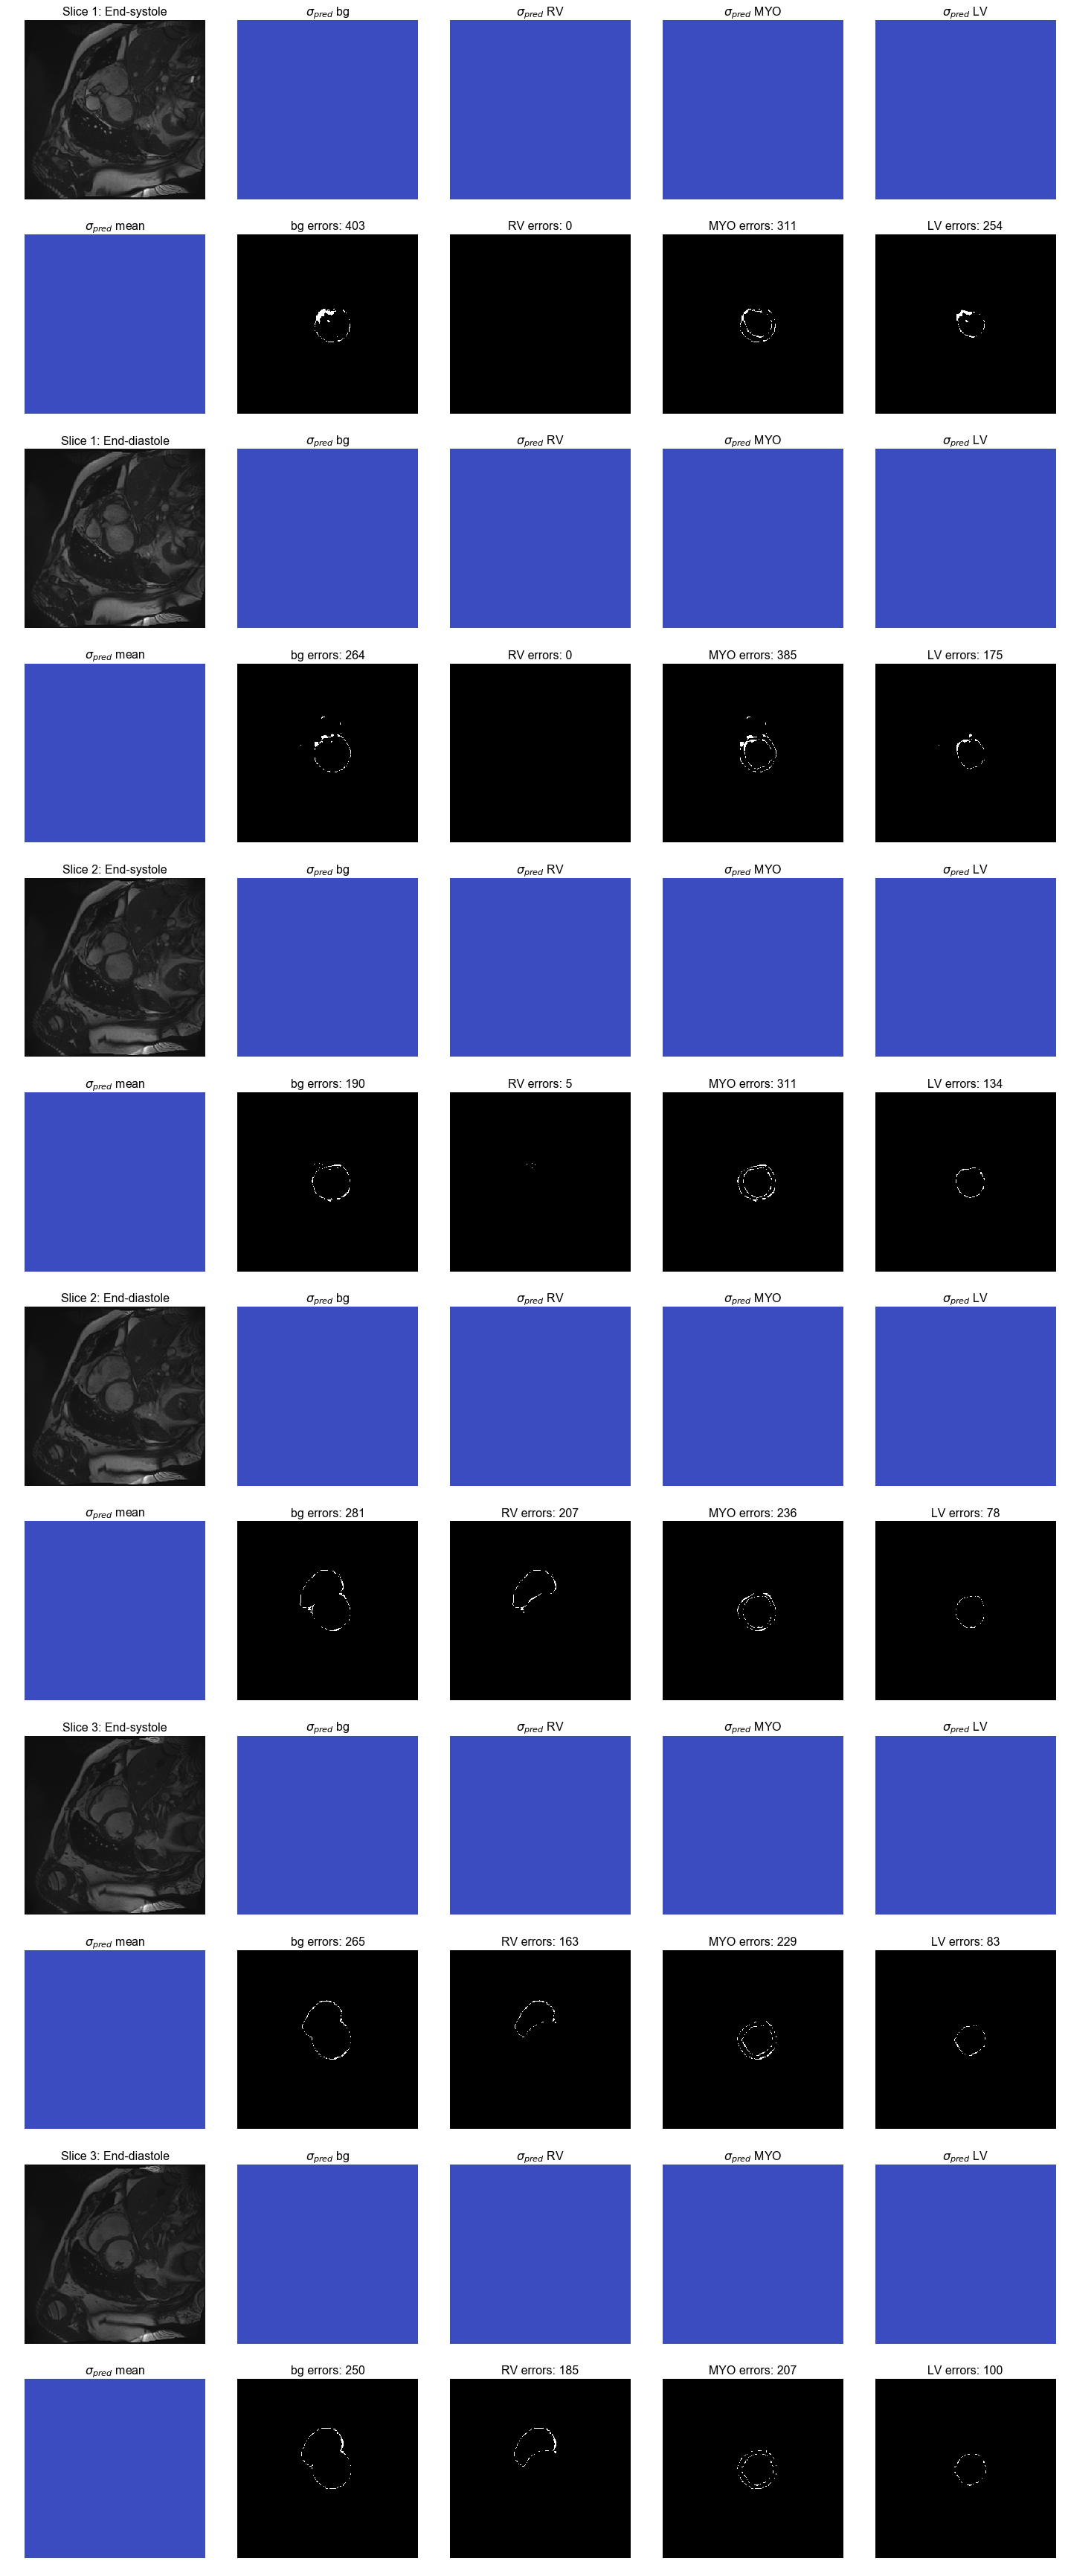

In [85]:
exper_hdl_base.test_results.visualize_prediction_uncertainty(width=20, height=120, slice_range=[0, 1, 2], 
                                                            do_save=False, std_threshold=None)

In [15]:
append_to_dir = os.path.join(exper_hdl_mc.exper.config.root_dir, exper_hdl_mc.exper.output_dir)
exper_hdl_mc.test_results.save_results()

Random number 815
INFO - Saved results to /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/stats/test_results_2018_03_15_08_35.dll


In [9]:
from utils.test_results import TestResults
save_path = os.path.join(exper_hdl_mc.exper.config.root_dir, 
                         os.path.join(exper_hdl_mc.exper.output_dir, exper_hdl_mc.exper.config.stats_path))
save_path = os.path.join(save_path, "test_results_950.dll")
test_results = TestResults.load_results(save_path)


Load from /home/jorg/repository/dcnn_acdc/logs/20180308_12_05_35_dcnn_mcv1_150000E_lr2e02/stats/test_results_950.dll


In [77]:
test_set.b_image_id

'patient030_frame01_frame12'

In [ ]:
# img_slice_stats = exper_hdl_mc.test_results.image_probs_categorized[0][0]
# print(img_slice_stats["es_mean_cor_p"].shape)
img = exper_hdl_mc.test_results.images[0]
fig = plt.figure(figsize=(12, 10))
img_slice = img[0][:, :, 5]
print(img_slice.shape)
fig, ax2 = plt.subplots(10, sharex=True, figsize=(10,100))
ax2[0].imshow(img_slice, cmap=cm.gray)
plt.show()